In [224]:
from typing import List, Union, TypeVar, Dict, Any, Optional, overload, Tuple

import matplotlib.pyplot as plt
import polars as pl
from glob import glob
import plotly.express as px
from plotly_resampler import register_plotly_resampler
import seaborn as sns
import panutil
from zipfile import ZipFile, ZIP_LZMA, ZIP_DEFLATED
import os
import numpy as np
from matplotlib.axes import Axes
from scipy.optimize import curve_fit

register_plotly_resampler(mode='auto')

In [154]:
def concat_results(fns: List[str], **kwargs):
    dfs = []
    for fn in fns:
        df = pl.read_csv(fn, skip_rows=6, **kwargs)
        if dfs:
            df = df.with_columns(
                pl.col("[run number]") + dfs[-1]["[run number]"].max() + 1
            )
        dfs.append(df)
    return pl.concat(dfs)


def parqify_results(
    fn_glob: str,
    csv_kwargs: Optional[Dict[str, Any]] = None,
    parq_kwargs: Optional[Dict[str, Any]] = None,
):
    csv_kwargs = csv_kwargs or dict()
    parq_kwargs = parq_kwargs or dict()

    single_fn = fn_glob.replace("*", "").replace(".csv", "")
    parq_fn = single_fn + ".parquet"
    zip_fn = single_fn + ".zip"
    try:
        return pl.read_parquet(parq_fn, **parq_kwargs)
    except Exception as e:
        fns = glob(fn_glob)
        fn_string = "\n\t".join(fns)
        print(f"Got {e}; reading CSVs:\n\t{fn_string}")
        results = concat_results(fns)
        print("Writing parquet")
        results.write_parquet(parq_fn)
        with ZipFile(zip_fn, "w", compression=ZIP_DEFLATED) as zip:
            print("Backing up to zip")
            for fn in fns:
                zip.write(fn)
            if zip.testzip() is None:
                print("Zip successful; removing CSVs")
                for fn in fns:
                    os.remove(fn)
            else:
                print("Zip failed; backup and remove manually")
        return results

sheep_see_order = ["none", "s", "w", "sw", "g", "sg", "wg", "swg"]
# wolves_see_order = ["none", "g", "w", "wg", "s", "sg", "sw", "swg"]
wolves_see_order = ["none", "s", "sg", "sw", "swg"]


In [124]:
sheep30x5 = parqify_results("data/2023-04-06-s-30x5-2000-sw-all-at-once-*.csv")
wolf30x5 = parqify_results("data/2023-04-06-w-30x5-2000-sw-all-at-once-*.csv")

Got No such file or directory: data/2023-04-06-s-30x5-2000-sw-all-at-once-.parquet; reading CSVs:
	data/2023-04-06-s-30x5-2000-sw-all-at-once-05.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-12.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-08.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-07.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-03.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-01.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-17.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-06.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-19.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-13.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-16.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-09.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-02.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-04.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-00.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-14.csv
	data/2023-04-06-s-30x5-2000-sw-all-at-once-11.csv
	data/2023-04-06-s-30x5-2000-sw-all

In [115]:
pl.read_csv(
    # "data/Wolf Sheep Predation - Micro-Sims 2023-04-07-w-12x1-2000-sw-all-at-once-table.csv",
    # "data/2023-04-06-w-30x5-2000-sw-all-at-once-/data/2023-04-06-w-30x5-2000-sw-all-at-once-02.csv",
    # "data/Wolf Sheep Predation - Micro-Sims 2023-04-07-w-5x5-2000-sw-all-at-once-table.csv",
    "data/2023-04-06-w-30x5-2000-sw-all-at-once-00.csv",
    skip_rows=6,
).filter(pl.col("wolf-sim-l") == 1).groupby(["[run number]", "wolf-sim-n"]).agg(pl.mean("wolf-efficiency")).sort("wolf-sim-n")


[run number],wolf-sim-n,wolf-efficiency
i64,i64,f64
1,1,0.850234
6,2,0.957979
11,3,1.020559
16,4,1.149936
21,5,1.193598
26,6,1.248093
31,7,1.265137
36,8,1.276121
41,9,1.291129


In [79]:
len(wolf30x5["[run number]"])
wolf30x5.filter(pl.col("wolf-sim-l") == 1).groupby(["[run number]", "wolf-sim-n"]).agg(pl.mean("wolf-efficiency")).sort(["wolf-sim-n"])

[run number],wolf-sim-n,wolf-efficiency
i64,i64,f64
454,1,0.857658
1,1,0.850137
756,1,0.834916
1209,1,0.852556
303,1,0.823419
1058,1,0.830329
1360,1,0.849539
152,1,0.849954
605,1,0.850223


In [ ]:
# px.line(
#     sheep30x5.filter(pl.col("[step]") > 1).with_columns(
#         [
#             pl.col("sheep-sim-l"),  # .cast(str),
#             pl.col("sheep-sim-n"),  # .cast(str),
#             pl.col("sheep-efficiency").over("[run number]"),
#         ]
#     )
#     .groupby(["[step]", "sheep-sim-n"])
#     .agg(pl.mean("sheep-efficiency"))
#     .sort(["sheep-sim-n", "[step]"])
#     .to_pandas(),
#     x="[step]",
#     y="sheep-efficiency",
#     color="sheep-sim-n",
#     # facet_row="sheep-sim-l"
# ).show()

px.box(
    sheep30x5.filter(pl.col("sheep-sim-n") < 10)
    # .groupby(["sheep-sim-l", "sheep-sim-n", "[run number]"])
    # .agg([
    #     # (pl.col("count wolves") > 0).sum(),
    #     (pl.mean("count wolves")),
    # ])
    # .groupby(["sheep-sim-l", "sheep-sim-n"])
    # .agg(pl.mean("count wolves"))
    .sort(["sheep-sim-n", "sheep-sim-l"])
    .to_pandas(),
    x="sheep-sim-n",
    y="count wolves",
    color="sheep-sim-l",
    points=False,

    # facet_row="sheep-sim-l"
).show()


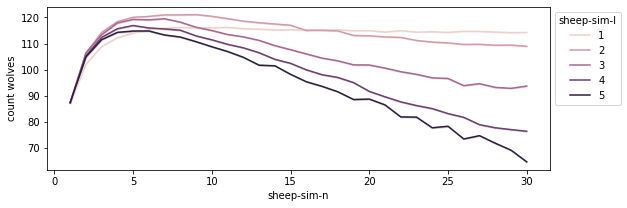

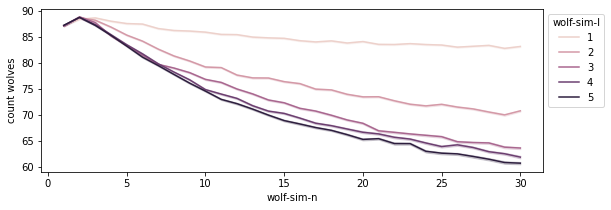

In [117]:
for df, species in [(sheep30x5, "sheep"), (wolf30x5,"wolf")]:
    plt.figure(figsize=(9,3))
    ax = sns.lineplot(
        data = df#.filter(pl.col("sheep-sim-n") < 10)
        .sort([f"{species}-sim-n", f"{species}-sim-l"])
        .to_pandas(),
        x=f"{species}-sim-n",
        y="count wolves",
        hue=f"{species}-sim-l",
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

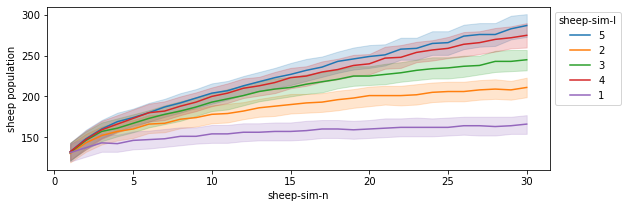

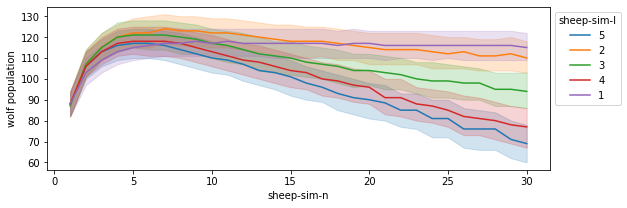

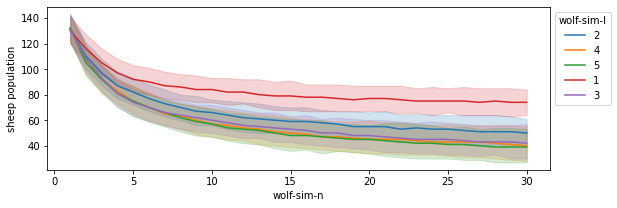

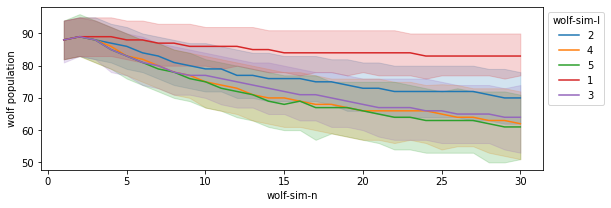

In [136]:
def plot_pop(df, sim_l, sim_n, count, label) -> Axes:
    plt.figure(figsize=(9, 3))
    ax = sns.lineplot(
        data=df.filter(pl.col("[step]") > 1000)
        .with_columns(pl.col(sim_l).cast(str))
        .to_pandas(),
        y=count,
        hue=sim_l,
        x=sim_n,
        errorbar=lambda xs: (np.quantile(xs, 0.25), np.quantile(xs, 0.75)),
        estimator="median",
    )
    ax.set(ylabel=label)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


plot_pop(
    sheep30x5, "sheep-sim-l", "sheep-sim-n", "count sheep", "sheep population"
).figure.savefig(
    "images/microsims-sheep-exp-sheep-pop.png", bbox_inches="tight", dpi=300
)
plot_pop(
    sheep30x5, "sheep-sim-l", "sheep-sim-n", "count wolves", "wolf population"
).figure.savefig(
    "images/microsims-sheep-exp-wolf-pop.png", bbox_inches="tight", dpi=300
)
plot_pop(
    wolf30x5, "wolf-sim-l", "wolf-sim-n", "count sheep", "sheep population"
).figure.savefig(
    "images/microsims-wolf-exp-sheep-pop.png", bbox_inches="tight", dpi=300
)
plot_pop(
    wolf30x5, "wolf-sim-l", "wolf-sim-n", "count wolves", "wolf population"
).figure.savefig("images/microsims-wolf-exp-wolf-pop.png", bbox_inches="tight", dpi=300)


In [126]:
@overload
def cumul_eff(pop: pl.Series, eff: pl.Series) -> float:
    ...


@overload
def cumul_eff(
    pop: Union[pl.Expr, pl.Series], eff: Union[pl.Expr, pl.Series]
) -> pl.Expr:
    ...


def cumul_eff(pop: Union[pl.Expr, pl.Series], eff: Union[pl.Expr, pl.Series]):
    # shift -1 because the efficiency of tick 3 was performed by the population
    # at the end of tick 2.
    # shift 1 to knock off the last pop, which didn't get a chance to eat
    # anything.
    return (eff.shift(-1) * pop).sum() / pop.shift(1).sum()


def stdize_out(
    value: pl.Expr, control_for: Union[str, pl.Expr, List[Union[pl.Expr, str]]]
) -> pl.Expr:
    return (value - value.mean().over(control_for)) / value.std().over(control_for)

@pl.api.register_expr_namespace("stat")
class Stat(object):
    def __init__(self, expr: pl.Expr):
        self._expr = expr

    def zscore(self)->pl.Expr:
        return (self._expr - self._expr.mean()) / self._expr.std()



/home/bryan/mambaforge/lib/python3.9/site-packages/polars/api.py:55: UserWarning: Overriding existing custom namespace 'stat' (on Expr)
  warn(


In [127]:
def summarize_runs(df: pl.DataFrame):
    return (
        df.groupby("[run number]", maintain_order=True)
        .agg(
            [
                pl.last("sheep-sim-n"),
                pl.last("sheep-sim-l"),
                pl.last("wolf-sim-n"),
                pl.last("wolf-sim-l"),
                pl.mean("count wolves").alias("mean_wolves"),
                pl.mean("count sheep").alias("mean_sheep"),
                pl.mean("grass").alias("mean_grass"),
                pl.col("[step]")
                .filter(pl.col("count wolves") > 0)
                .max()
                .alias("wolf_survival"),
                cumul_eff(pl.col("count sheep"), pl.col("sheep-efficiency")).alias(
                    "sheep_eff"
                ),
                cumul_eff(pl.col("count wolves"), pl.col("sheep-escape-efficiency")).alias(
                    "sheep_escape_eff"
                ),
                cumul_eff(pl.col("count wolves"), pl.col("wolf-efficiency")).alias(
                    "wolf_eff"
                ),
            ]
        )
    )
sheep_runs_bi = summarize_runs(sheep30x5.filter(pl.col("[step]") > 1000))
wolf_runs_bi = summarize_runs(wolf30x5.filter(pl.col("[step]") > 1000))
sheep_runs = summarize_runs(sheep30x5)
wolf_runs = summarize_runs(wolf30x5)

<AxesSubplot:xlabel='sheep-sim-n', ylabel='sheep survival rate'>

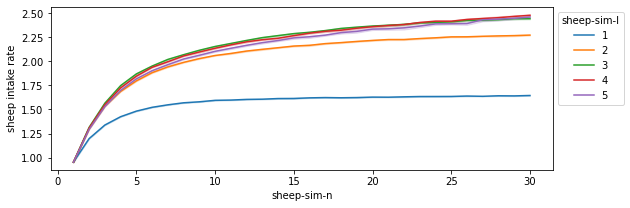

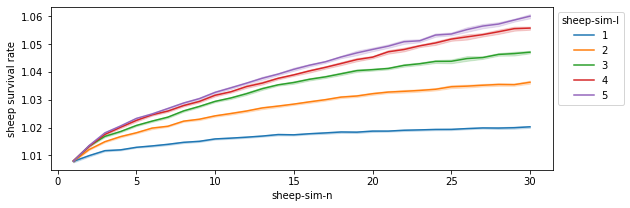

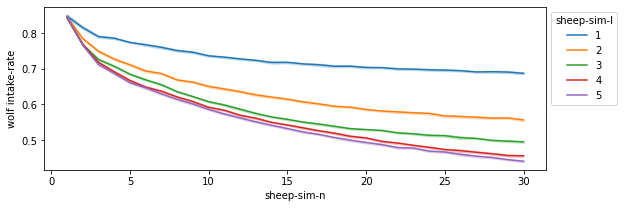

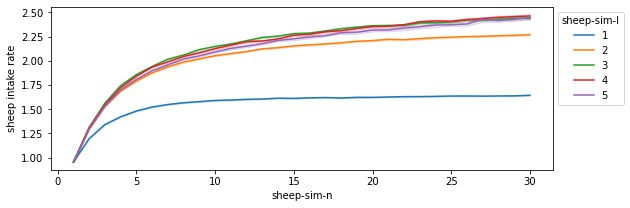

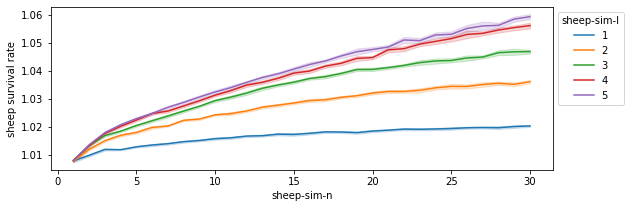

In [144]:
def plot_eff(df: pl.DataFrame, sim_l: str, sim_n: str, eff: str, label: str) -> Axes:
    plt.figure(figsize=(9, 3))
    ax = sns.lineplot(
        x=sim_n,
        y=eff,
        hue=sim_l,
        data=df.with_columns(pl.col(sim_l).cast(str)).to_pandas(),
        hue_order=df[sim_l].unique().sort().cast(str),
    )
    ax.set(ylabel=label)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


plot_eff(
    sheep_runs, "sheep-sim-l", "sheep-sim-n", "sheep_eff", "sheep intake rate"
).figure.savefig(
    "images/microsims_sheep_exp_sheep_eff.png", bbox_inches="tight", dpi=300
)

plot_eff(
    sheep_runs, "sheep-sim-l", "sheep-sim-n", "sheep_escape_eff", "sheep survival rate"
).figure.savefig(
    "images/microsims_sheep_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300
)

plot_eff(
    sheep_runs, "sheep-sim-l", "sheep-sim-n", "wolf_eff", "wolf intake-rate"
).figure.savefig(
    "images/microsims_sheep_exp_wolf_eff.png", bbox_inches="tight", dpi=300
)
plot_eff(
    sheep_runs_bi, "sheep-sim-l", "sheep-sim-n", "sheep_eff", "sheep intake rate"
)
plot_eff(
    sheep_runs_bi, "sheep-sim-l", "sheep-sim-n", "sheep_escape_eff", "sheep survival rate"
)

In [280]:
display(sheep_runs.sort("sheep-sim-l").pivot(
    values="sheep_eff", columns="sheep-sim-l", index="sheep-sim-n", aggregate_fn="mean"
).sort("sheep-sim-n"))
display(sheep_runs.sort("sheep-sim-l").pivot(
    values="sheep_escape_eff", columns="sheep-sim-l", index="sheep-sim-n", aggregate_fn="mean"
).sort("sheep-sim-n"))
display(wolf_runs.sort("wolf-sim-l").pivot(
    values="wolf_eff", columns="wolf-sim-l", index="wolf-sim-n", aggregate_fn="mean"
).sort("wolf-sim-n"))



sheep-sim-n,1,2,3,4,5
i64,f64,f64,f64,f64,f64
1,0.954059,0.953713,0.953053,0.953256,0.953052
2,1.198264,1.298722,1.314892,1.308383,1.294556
3,1.339014,1.534454,1.565728,1.550022,1.531773
4,1.425245,1.687411,1.747684,1.72428,1.698322
5,1.482939,1.796774,1.868958,1.845585,1.81771
6,1.522555,1.882004,1.950535,1.937576,1.902183
7,1.548327,1.941718,2.019171,1.995249,1.964854
8,1.569352,1.988789,2.068188,2.055476,2.023415
9,1.57958,2.02781,2.114063,2.096147,2.06223


sheep-sim-n,1,2,3,4,5
i64,f64,f64,f64,f64,f64
1,1.007861,1.007914,1.008039,1.008087,1.007927
2,1.009929,1.012127,1.013409,1.013333,1.013565
3,1.011711,1.014935,1.016852,1.017562,1.018104
4,1.012009,1.016769,1.018595,1.02014,1.020598
5,1.012926,1.018146,1.020765,1.022574,1.0233
6,1.013412,1.019818,1.022334,1.024608,1.024898
7,1.013986,1.020487,1.023756,1.025934,1.026853
8,1.014708,1.022319,1.025996,1.027918,1.028822
9,1.015072,1.023009,1.027609,1.029398,1.030397


wolf-sim-n,1,2,3,4,5
i64,f64,f64,f64,f64,f64
1,0.848427,0.843451,0.847426,0.842644,0.845255
2,0.954997,1.004125,1.027038,1.036404,1.041415
3,1.042044,1.132684,1.182171,1.19508,1.202182
4,1.136023,1.250807,1.36206,1.333321,1.348384
5,1.187987,1.345868,1.467614,1.450271,1.462242
6,1.219427,1.423827,1.557033,1.55267,1.56941
7,1.264867,1.494386,1.64476,1.651809,1.674222
8,1.280145,1.563841,1.689692,1.735541,1.761861
9,1.300942,1.613284,1.744124,1.807073,1.834715


[2.76906430e+03 2.74836085e+03 3.75624951e-03]
4.863469881677442e-07
1.0139859932349038
[9.28445770e+04 9.23894655e+04 8.75912613e-03]
1.7977909352207798e-06
1.0204874650076732
[3.25338419e+04 3.24499383e+04 1.23295065e-02]
4.2346398634022165e-06
1.0237557175350485
[1.12844970e+05 1.12856431e+05 1.49317013e-02]
1.0020299251225625e-05
1.0259341628089758
[1.85384046e+05 1.85572301e+05 1.59703090e-02]
1.1974996350467187e-05
1.0268525812107283


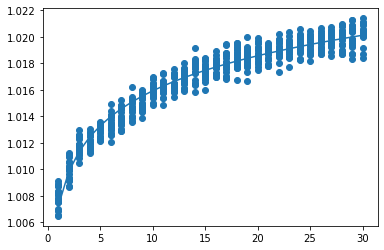

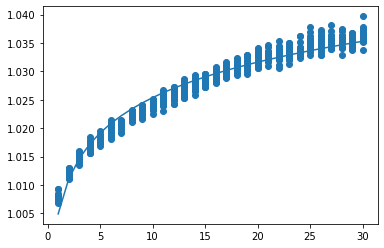

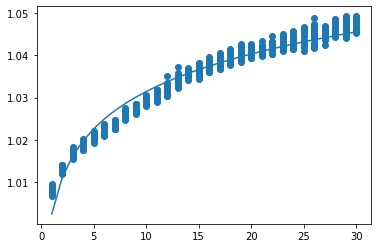

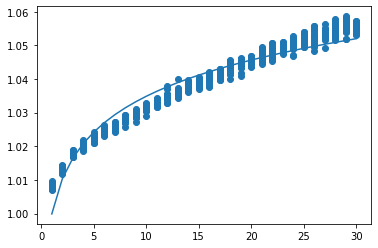

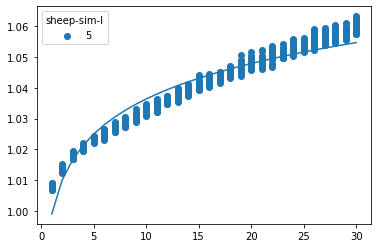

In [279]:
# # plot_eff(
# #     sheep_runs, "sheep-sim-l", "sheep-sim-n", "sheep_eff", "sheep intake rate"
# # )
# sns.scatterplot(
#     sheep_runs.sort("sheep-sim-l").with_columns(pl.col("sheep-sim-l").cast(str)).to_pandas(),
#     x="sheep-sim-n",
#     y="sheep_eff",
#     hue="sheep-sim-l",
# )


def asymptotic_f(x, a, b, n):
    return a * x ** n / (x ** n + b)


# def asymptotic_f(x, b0, b1, lrc):
#     return b0 + b1 * (1-np.exp(-np.exp(lrc) * x))
# def asymptotic_f(x, a, b, c):
#     return a - (a - b) * np.exp(-c * x)
for l in sheep_runs["sheep-sim-l"].sort().unique():
    plt.figure()
    y, x = (
        sheep_runs.filter((pl.col("sheep-sim-l") == l))
        .select(["sheep_escape_eff", "sheep-sim-n"])
        .sort("sheep-sim-n")
        .to_numpy()
        .T
    )
    plt.scatter(x, y, label=l)
    popt, pcov = curve_fit(asymptotic_f, x, y, maxfev=2000)
    xs = np.linspace(1, 100, 100)
    plt.plot(x, asymptotic_f(x, *popt))
    print(popt)
    print(np.sum((asymptotic_f(x, *popt) - y) ** 2) / len(y))
    print(
        sheep_runs.filter((pl.col("sheep-sim-l") == l) & (pl.col("sheep-sim-n") == 7))["sheep_escape_eff"].mean()
    )
    # print(np.sum((y - asymptotic_f(x, *popt)) ** 2 / ))
plt.legend(title="sheep-sim-l")


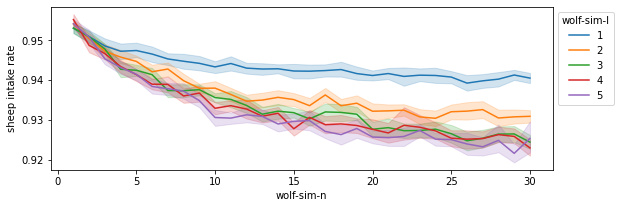

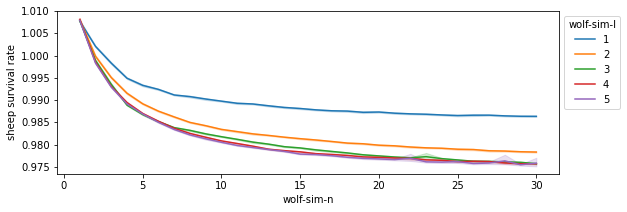

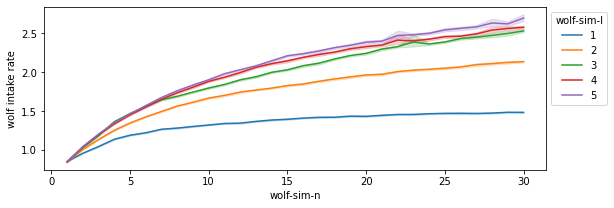

In [140]:
plot_eff(
    wolf_runs, "wolf-sim-l", "wolf-sim-n", "sheep_eff", "sheep intake rate"
).figure.savefig(
    "images/microsims_wolf_exp_sheep_eff.png", bbox_inches="tight", dpi=300
)
plot_eff(
    wolf_runs, "wolf-sim-l", "wolf-sim-n", "sheep_escape_eff", "sheep survival rate"
).figure.savefig(
    "images/microsims_wolf_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300
)
plot_eff(
    wolf_runs, "wolf-sim-l", "wolf-sim-n", "wolf_eff", "wolf intake rate"
).figure.savefig("images/microsims_wolf_exp_wolf_eff.png", bbox_inches="tight", dpi=300)


In [105]:
perception_sweep = parqify_results(
    "data/2023-01-20-s-n_3_6_9-l_3-w-n_3_9_30-l_5-perception-sweep*.csv"
).filter((pl.col("sheep-sim-n") == 9) & (pl.col("wolf-sim-n") == 9))


In [106]:
perception_sweep = perception_sweep.with_columns(
    [
        sum(
            (
                pl.when(pl.col(f"{species}-see-{agents}?")).then(agents[0]).otherwise("")
                for agents in ["sheep", "wolves", "grass"]
            ),
            start=pl.lit(""),
        ).alias(f"{species}-see").str.replace("^$", "none")
        for species in ["sheep", "wolves"]
    ]
)


In [12]:
perception_sweep.columns

['[run number]',
 'wolf-gain-from-food',
 'wolf-vision',
 'sheep-threshold',
 'initial-number-wolves',
 'initial-number-sheep',
 'sheep-vision',
 'death-penalty',
 'wolf-threshold',
 'sheep-gain-from-food',
 'grass-regrowth-time',
 'initial-grass-density',
 'newborn-energy',
 'wolves-see-sheep?',
 'wolves-see-grass?',
 'wolves-see-wolves?',
 'wolf-sim-n',
 'wolf-sim-l',
 'sheep-see-sheep?',
 'sheep-see-grass?',
 'sheep-see-wolves?',
 'sheep-sim-n',
 'sheep-sim-l',
 '[step]',
 'count sheep',
 'count wolves',
 'grass',
 'patches-with-sheep',
 'sheep-efficiency',
 'sheep-escape-efficiency',
 'wolf-efficiency',
 'sheep-see',
 'wolves-see']

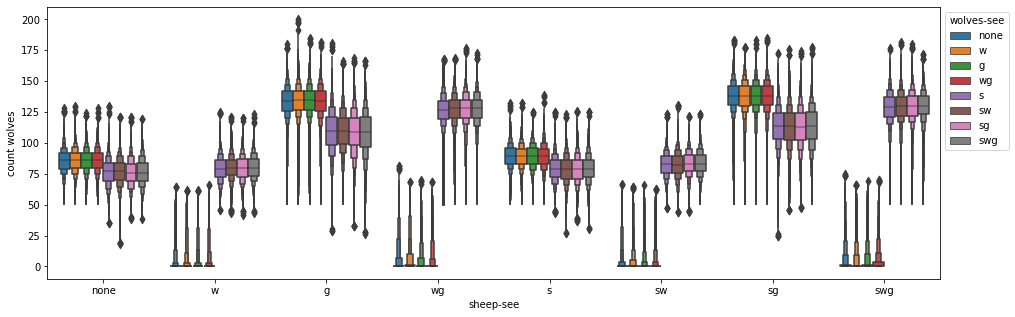

In [107]:

# px.box(
#     perception_sweep
#     .sort(["sheep-sim-n", "sheep-sim-l"])
#     .to_pandas(),
#     facet_col="sheep-sim-n",
#     facet_row="wolf-sim-n",
#     x="sheep-see",
#     y="count wolves",
#     color="wolves-see",
#     points=False,
#     # facet_row="sheep-sim-l"
# ).show()
# sns.FacetGrid(
#     perception_sweep.to_pandas(),
#     row="sheep-sim-n",
#     col="wolf-sim-n",
#     aspect=2,
# ).map_dataframe(
#     sns.boxenplot,
#     x="sheep-see",
#     y="count wolves",
#     hue="wolves-see",
#     palette=sns.color_palette(),
# ).add_legend()
plt.figure(figsize=(16, 5))
ax = sns.boxenplot(
    perception_sweep.to_pandas(),
    x="sheep-see",
    y="count wolves",
    hue="wolves-see",
    palette=sns.color_palette(),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


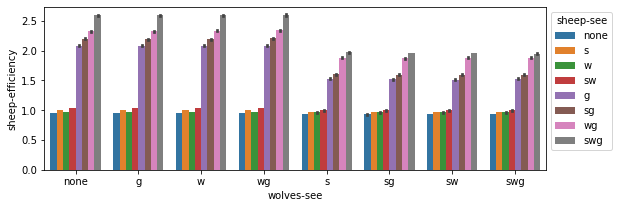

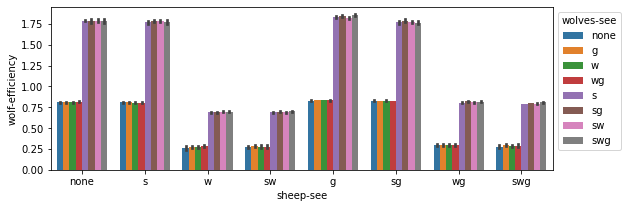

In [145]:
df = (
    perception_sweep.groupby(
        ["sheep-sim-n", "wolf-sim-n", "sheep-see", "wolves-see", "[run number]"]
    )
    .agg(
        [
            cumul_eff(pl.col("count sheep"), pl.col("sheep-efficiency")),
            cumul_eff(pl.col("count wolves"), pl.col("wolf-efficiency")),
        ]
    )
    .sort(["sheep-see", "wolves-see"])
)
# sns.FacetGrid(df, row="sheep-sim-n", col="wolf-sim-n", aspect=2,).map_dataframe(
#     sns.barplot,
#     hue="sheep-see",
#     y="sheep-efficiency",
#     x="wolves-see",
#     hue_order=sheep_see_order,
#     order=sheep_see_order,
#     palette=sns.color_palette(),
# ).add_legend()

# sns.FacetGrid(df, row="sheep-sim-n", col="wolf-sim-n", aspect=2,).map_dataframe(
#     sns.barplot,
#     x="sheep-see",
#     y="wolf-efficiency",
#     hue="wolves-see",
#     order=sheep_see_order,
#     hue_order=sheep_see_order,
#     palette=sns.color_palette(),
# ).add_legend()
plt.figure(figsize=(9, 3))
ax = sns.barplot(
    df.to_pandas(),
    hue="sheep-see",
    y="sheep-efficiency",
    x="wolves-see",
    hue_order=sheep_see_order,
    order=wolves_see_order,
    palette=sns.color_palette(),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(9, 3))
ax = sns.barplot(
    df.to_pandas(),
    x="sheep-see",
    y="wolf-efficiency",
    hue="wolves-see",
    order=sheep_see_order,
    hue_order=wolves_see_order,
    palette=sns.color_palette(),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [146]:
wudf = parqify_results(
    "data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once*.csv"
).with_columns(
    [
        sum(
            (
                pl.when(pl.col(f"{species}-see-{agents}?"))
                .then(agents[0])
                .otherwise("")
                for agents in ["sheep", "wolves", "grass"]
            ),
            start=pl.lit(""),
        )
        .alias(f"{species}-see")
        .str.replace("^$", "none")
        for species in ["sheep", "wolves"]
    ]
)


Got No such file or directory: data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once.parquet; reading CSVs:
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-12.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-05.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-02.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-07.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-03.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-11.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-19.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-01.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once-10.csv
	data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-

In [147]:
wudf_runs = wudf.groupby(
    [
        "[run number]",
        "wolves-see",
        "sheep-see",
        "sheep-sim-warmup",
        "sheep-sim-n",
        "wolf-sim-warmup",
        "wolf-sim-n",
    ]
).agg([
    cumul_eff(pl.col("count sheep"), pl.col("sheep-efficiency")),
    cumul_eff(pl.col("count wolves"), pl.col("sheep-escape-efficiency")),
    cumul_eff(pl.col("count wolves"), pl.col("wolf-efficiency")),
    pl.mean("count sheep").alias("sheep-pop"),
    pl.mean("count wolves").alias("wolf-pop"),
    pl.mean("grass").alias("grass-pop"),
])


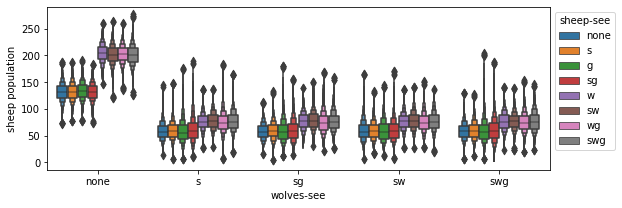

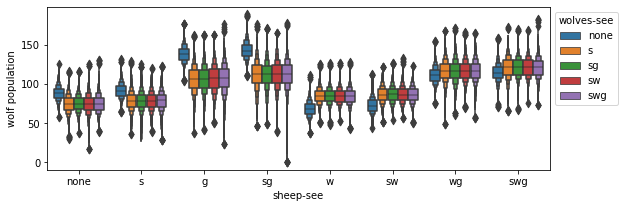

In [172]:
def plot_pop_dists(
    df: pl.DataFrame,
    x: Tuple[str, List[str]],
    hue: Tuple[str, List[str]],
    y: Tuple[str, str],
) -> Axes:
    plt.figure(figsize=(9, 3))
    ax = sns.boxenplot(
        df.to_pandas(),
        x=x[0],
        y=y[0],
        hue=hue[0],
        order=x[1],
        hue_order=hue[1],
        palette=sns.color_palette(),
    )
    ax.set_ylabel(y[1])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


wso_pop = ["none", "s", "sg", "sw", "swg"]
sso_pop = ["none", "s", "g", "sg", "w", "sw", "wg", "swg"]
wudf_no_wu = wudf.filter(
    (pl.col("[step]") > 1000)
    & (pl.col("sheep-sim-warmup") == 0)
    & (pl.col("wolf-sim-warmup") == 0)
)
plot_pop_dists(
    wudf_no_wu,
    ("wolves-see", wso_pop),
    ("sheep-see", sso_pop),
    ("count sheep", "sheep population"),
).figure.savefig("images/microsims_sees_exp_sheep_pop.png", bbox_inches="tight", dpi=300)
plot_pop_dists(
    wudf_no_wu,
    ("sheep-see", sso_pop),
    ("wolves-see", wso_pop),
    ("count wolves", "wolf population"),
).figure.savefig("images/microsims_sees_exp_wolf_pop.png", bbox_inches="tight", dpi=300)


sheep warmup 0; wolf warmup 0
sheep warmup 0; wolf warmup 6
sheep warmup 6; wolf warmup 0
sheep warmup 6; wolf warmup 6


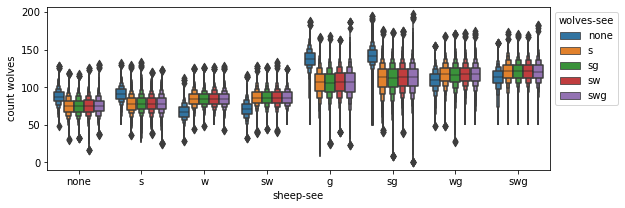

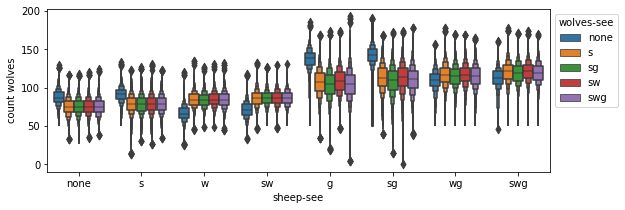

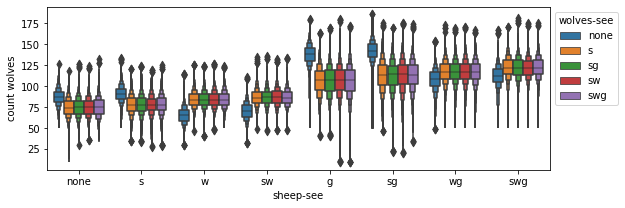

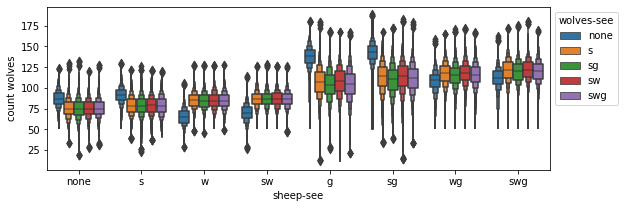

In [161]:
for sheep_wu in wudf["sheep-sim-warmup"].unique():
    for wolf_wu in wudf["wolf-sim-warmup"].unique():
        print(f"sheep warmup {sheep_wu}; wolf warmup {wolf_wu}")
        plt.figure(figsize=(9, 3))
        ax = sns.boxenplot(
            wudf.filter(
                (pl.col("sheep-sim-warmup") == sheep_wu)
                & (pl.col("wolf-sim-warmup") == wolf_wu)
            ).to_pandas(),
            x="sheep-see",
            y="count wolves",
            hue="wolves-see",
            hue_order=wolves_see_order,
            order=sheep_see_order,
            palette=sns.color_palette(),
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


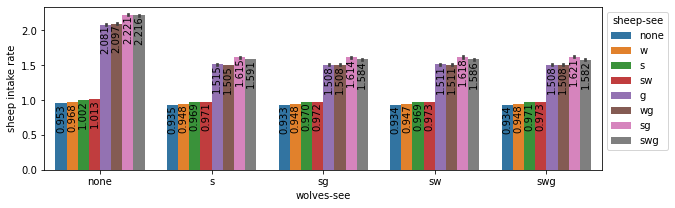

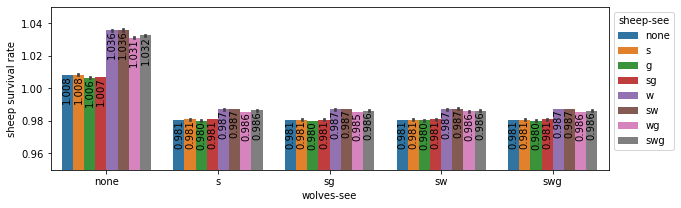

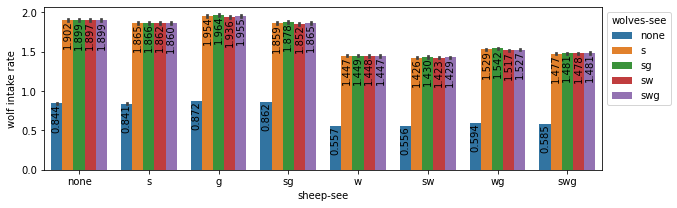

In [218]:
def plot_eff_over_sees(
    df: pl.DataFrame,
    eff: Tuple[str, str],
    x: Tuple[str, List[Any]],
    hue: Tuple[str, List[Any]],
    fmt: str = "{:.3f}",
    yoff: float = 0,
    figsize=(10,3)
) -> Axes:
    plt.figure(figsize=figsize)
    ax: Axes = sns.barplot(
        df.to_pandas(),
        y=eff[0],
        x=x[0],
        order=x[1],
        hue=hue[0],
        hue_order=hue[1],
        palette=sns.color_palette(),
    )
    ax.set_ylabel(eff[1])
    panutil.show_values_on_bars(ax, 90, fmt=fmt, yoff=yoff)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


    # g: sns.FacetGrid = sns.catplot(
    #     df.to_pandas(),
    #     y=eff,
    #     x=x[0],
    #     order=x[1],
    #     col=hue[0],
    #     col_order=hue[1],
    #     kind="bar",
    #     palette=sns.color_palette(),
    #     height=3,
    #     aspect=aspect,
    # )

    # g.set_xticklabels(rotation=90)

    # #panutil.show_values_on_bars(ax, 90, fmt=fmt)
    # #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # return g


# def plot_eff_over_sees(
#     df: pl.DataFrame, eff: str, eff_species: str, other_species: str
# ):
#     plt.figure(figsize=(9, 3))
#     ax = sns.barplot(
#         df.to_pandas(),
#         hue=f"{eff_species}-see",
#         y=eff,
#         x=f"{other_species}-see",
#         hue_order=sheep_see_order if eff_species == "sheep" else wolves_see_order,
#         order=wolves_see_order if eff_species == "sheep" else wolves_see_order,
#         palette=sns.color_palette(),
#     )
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     return ax

sso_eff = ["none", "w", "s", "sw", "g", "wg", "sg", "swg"]
wso_eff = ["none", "s", "sg", "sw", "swg"]

wudf_run_no_wu = wudf_runs.filter(
    (pl.col("sheep-sim-warmup") == 0) & (pl.col("wolf-sim-warmup") == 0)
)
plot_eff_over_sees(
    wudf_run_no_wu,
    ("sheep-efficiency", "sheep intake rate"),
    ("wolves-see", wso_eff),
    ("sheep-see", sso_eff),
).figure.savefig("images/microsims_sees_exp_sheep_eff.png", bbox_inches="tight", dpi=300)

ax = plot_eff_over_sees(
    wudf_run_no_wu,
    ("sheep-escape-efficiency", "sheep survival rate"),
    ("wolves-see", wso_eff),
    ("sheep-see", sso_pop),
)
ax.set_ylim(0.95, 1.05)
ax.figure.savefig("images/microsims_sees_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300)

plot_eff_over_sees(
    wudf_run_no_wu,
    ("wolf-efficiency", "wolf intake rate"),
    ("sheep-see", sso_pop),
    ("wolves-see", wso_eff),
).figure.savefig("images/microsims_sees_exp_wolf_eff.png", bbox_inches="tight", dpi=300)


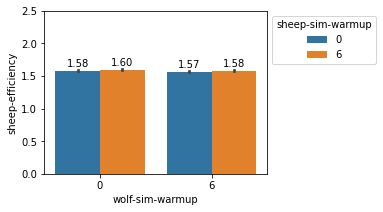

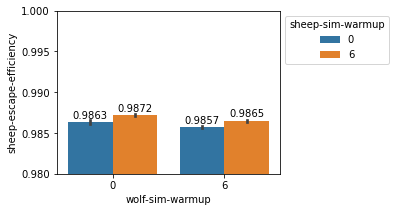

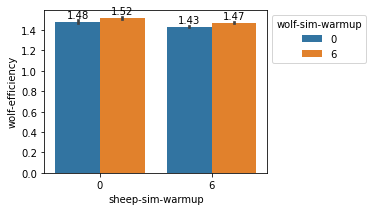

In [151]:
wu_see_all = wudf_runs.filter((pl.col("sheep-see")=="swg") & (pl.col("wolves-see")=="swg"))

plt.figure(figsize=(4,3))
ax = sns.barplot(
    wu_see_all.to_pandas(),
    hue="sheep-sim-warmup",
    y="sheep-efficiency",
    x="wolf-sim-warmup",
    palette=sns.color_palette(),
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.2f", padding=2)
ax.set_ylim((0, 2.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(4,3))
ax = sns.barplot(
    wu_see_all.to_pandas(),
    hue="sheep-sim-warmup",
    y="sheep-escape-efficiency",
    x="wolf-sim-warmup",
    palette=sns.color_palette(),
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.4f", padding=2)
ax.set_ylim((0.98, 1.00))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(4,3))
ax = sns.barplot(
    wu_see_all.to_pandas(),
    x="sheep-sim-warmup",
    y="wolf-efficiency",
    hue="wolf-sim-warmup",
    palette=sns.color_palette(),
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.2f", padding=2)
#ax.set_ylim((0, 1.0))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


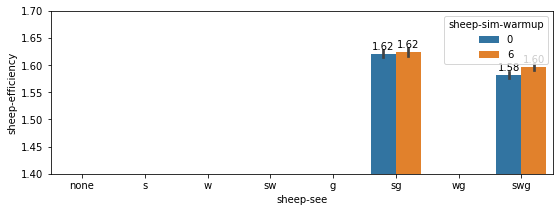

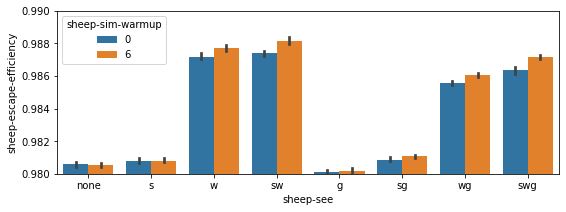

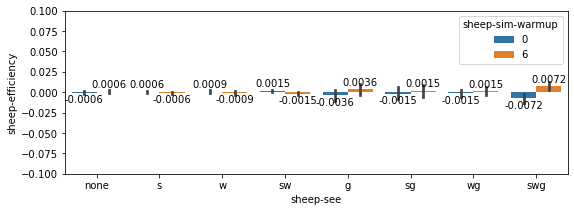

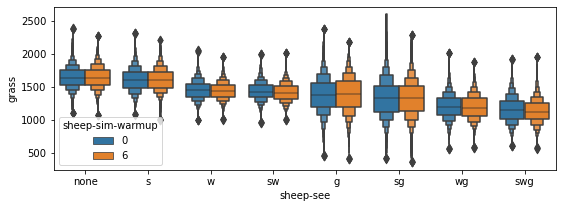

In [288]:
plt.figure(figsize=(9, 3))
ax = sns.barplot(
    wudf_runs.filter(
        (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
        & (pl.col("sheep-see").str.contains("s"))
    ).to_pandas(),
    x="sheep-see",
    y="sheep-efficiency",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.2f", padding=2)
ax.set_ylim((1.4, 1.7))

plt.figure(figsize=(9, 3))
ax = sns.barplot(
    wudf_runs.filter(
        (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
    ).to_pandas(),
    x="sheep-see",
    y="sheep-escape-efficiency",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)
ax.set_ylim((0.98, 0.99))

plt.figure(figsize=(9, 3))
ax = sns.barplot(
    wudf_runs.filter((pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg"))
    .with_columns(
        ((pl.col("sheep-efficiency") - pl.mean("sheep-efficiency"))).over("sheep-see")
        

    )
    .to_pandas(),
    x="sheep-see",
    y="sheep-efficiency",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.4f", padding=2)
ax.set_ylim((-.1, 0.1))

plt.figure(figsize=(9, 3))
ax = sns.boxenplot(
    wudf.filter(
        (pl.col("[step]") > 1000)
        & (pl.col("wolf-sim-warmup") == 0)
        & (pl.col("wolves-see") == "swg")
    ).to_pandas(),
    x="sheep-see",
    y="grass",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)


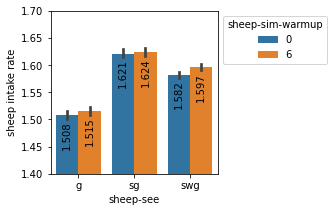

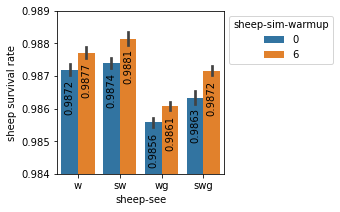

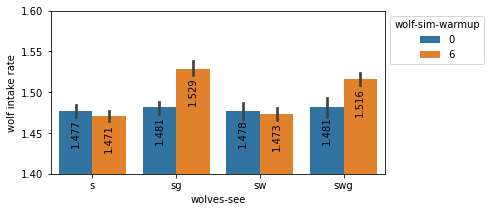

In [302]:
ax = plot_eff_over_sees(
    wudf_runs.filter(
        (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
    ),
    ("sheep-efficiency", "sheep intake rate"),
    ("sheep-see", ["g", "sg", "swg"]),
    ("sheep-sim-warmup", [0, 6]),
    yoff=-0.01,
    figsize=(3, 3),
)
ax.set_ylim(1.4, 1.7)
ax.figure.savefig(
    "images/microsims_warmup_exp_sheep_eff.png", bbox_inches="tight", dpi=300
)

ax = plot_eff_over_sees(
    wudf_runs.filter(
        (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
    ),
    ("sheep-escape-efficiency", "sheep survival rate"),
    ("sheep-see", ["w", "sw", "wg", "swg"]),
    ("sheep-sim-warmup", [0, 6]),
    yoff=-0.0003,
    figsize=(3, 3),
    fmt="{:.4f}",
)
ax.set_ylim(0.984, 0.989)
ax.figure.savefig(
    "images/microsims_warmup_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300
)

ax = plot_eff_over_sees(
    wudf_runs.filter(
        (pl.col("sheep-sim-warmup") == 0) & (pl.col("sheep-see") == "swg")
    ),
    ("wolf-efficiency", "wolf intake rate"),
    ("wolves-see", ["s", "sg", "sw", "swg"]),
    ("wolf-sim-warmup", [0, 6]),
    yoff=-0.01,
    figsize=(6, 3),
)
ax.set_ylim(1.4, 1.6)
ax.figure.savefig(
    "images/microsims_warmup_exp_wolf_eff.png", bbox_inches="tight", dpi=300
)
